# Dithering Algorithms
Dithering is used in computer graphics to create the illusion of "color depth" in images with a limited color palette - a technique also known as color quantization. In a dithered image, colors that are not available in the palette are approximated by a diffusion of colored pixels from within the available palette.

In [51]:
### import libs ###
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.animation as animation # for animated display with matplotlib
from IPython.display import HTML

from IPython.display import display # to display images
from PIL import Image # load images
from scipy.signal import convolve2d # for 2d image convolution


plt.rcParams['figure.figsize'] = [18,12] # resize default image display
plt.rcParams['figure.dpi'] = 80
plt.rcParams['animation.html'] = 'jshtml'# default setting for rendering animation as js htlm

In [11]:
# Minimal code for rendering a numpy array as an image with subplotting
def displayImg(array, subplot, cmap = None, title = None):
    axes = plt.subplot(subplot)
    # matplotlib adjust pixel scale intensity so use fixed vmin & vmax
    axes.imshow(array, cmap = cmap, vmin = 0, vmax = 255)
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    if title != None:
        axes.set_title(title)

# usefull function to display animated img
def animateImages(imgList, titleList  = [], cmap = None, interval = 20):
  def init():
    img.set_data(imgList[0])
    return (img,)

  def animate(i):
    img.set_data(imgList[i])
    if len(titleList) >= i + 1 :
        ax.set_title(titleList[i])
    return (img,)

  fig = plt.figure()
  ax = fig.gca() # get axes
  img = ax.imshow(imgList[0], cmap = cmap, vmin = 0, vmax = 255)
  return animation.FuncAnimation(fig, animate, init_func=init, frames=len(imgList), interval = interval, blit=True)


In [12]:
# greyscale conversion function with numpy
def meanGrayscaleConversion(img):
    # taking the average of three R, G & B components
    return np.mean(img, axis=2)

def weightedGrayscaleConversion(img, weights = [0.2989, 0.5870, 0.1140]):
    # taking the sum of weighted R, G & B components
    # using by default the standard ITU-R BT.601 Studio encoding parameters reconstructs the luminance
    # we can alos choose the  Rec. 709 coefficients [0.2126, 0.7152, 0.0722]
    weightsTiles = np.tile(weights, reps=(img.shape[0], img.shape[1], 1))
    return np.sum(weightsTiles * img, axis=2)
    # or return np.array([[ np.sum(weights * pixel) for pixel in line] for line in img])

In [13]:
img = Image.open('exemple01.jpg') #  load exemple image
imgArray = np.array(img, dtype = np.integer) # convert to numpy array

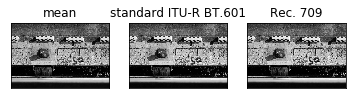

In [14]:
# grayScale conversion
grayscaleMeanImg = meanGrayscaleConversion(imgArray)
grayscaleRec709Img = weightedGrayscaleConversion(imgArray, [0.2126, 0.7152, 0.0722]) 
grayscaleImg = weightedGrayscaleConversion(imgArray)

displayImg(grayscaleMeanImg, subplot=131, cmap='gray', title= 'mean')
displayImg(grayscaleImg, subplot=132, cmap='gray', title= 'standard ITU-R BT.601')
displayImg(grayscaleRec709Img, subplot=133, cmap='gray', title= 'Rec. 709')


In [27]:
%%capture 
# adding capture here to prevent the returned output from being evaluated by Jupyter (only the animation displayed in the next cell)
#test animated display
anim = animateImages([grayscaleMeanImg, grayscaleImg, grayscaleRec709Img], ['mean', 'standard ITU-R BT.601', 'Rec. 709'], cmap='gray', interval = 1000)

In [28]:
HTML(anim.to_jshtml())

In [15]:
def threshold(img, rate = 0.5):
    ditheredImg = np.copy(img)
    # for ix, iy in np.ndindex(ditheredImg.shape):
    #     print(ditheredImg[ix,iy])
    ditheredImg = np.array([[255 if val > 256 * rate else 0 for val in line] for line in ditheredImg])
    return ditheredImg

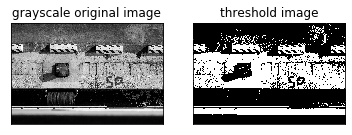

In [16]:
thresholdImg = threshold(grayscaleImg, 0.5)

displayImg(grayscaleImg, subplot=121, cmap='gray', title= 'grayscale original image')
displayImg(thresholdImg, subplot=122, cmap='gray', title= 'threshold image')

In [48]:
%%capture
# adding capture here to prevent the returned output from being evaluated by Jupyter (only the animation displayed in the next cell)
thresholdEvolutionRate = []
titles = []
for rate in np.arange(0.05, 1, 0.05):
    thresholdEvolutionRate.append( threshold(grayscaleImg, rate) )
    titles.append('rate : ' + str(round(rate,2)))
anim = animateImages(thresholdEvolutionRate, titles, cmap='gray', interval = 500)

In [49]:
HTML(anim.to_jshtml())

In [17]:
def npConvolve2d(img, convFilter, paddingMode = 'zero', debug = False):
    ''' Convolve an image with convFilter using zero-padding mode
    '''
    paddingSize = tuple(np.array(convFilter.shape)//2)
    if paddingMode == 'zero' :
        paddedImg = np.pad(img, (paddingSize, paddingSize), 'constant', constant_values= 0)
    else :
        paddedImg = np.pad(img, (paddingSize, paddingSize), paddingMode)
    subShape = convFilter.shape + tuple(np.subtract(paddedImg.shape, convFilter.shape) + 1)
    strd = np.lib.stride_tricks.as_strided # alias for the strided function
    subMatrices = strd(paddedImg, shape=subShape, strides=paddedImg.strides*2)
    convolved = np.einsum('ij,ijkl->kl', convFilter, subMatrices)

    if debug:
        print('img : '); print(img)
        print('convFilter : '); print(convFilter)
        print('padded img :'); print(paddedImg)
        print('subShape :'); print(subShape)
        print('subMatrices :'); print(subMatrices)
    return convolved

In [18]:
# convolution test on simple 
i = np.array([1,2,2,2,9,9,8,7,1,2,1,6]).reshape(3,4)
f = np.array([-3,-2,-1,0,0,0,3,2,1]).reshape(3,3)
strider = np.lib.stride_tricks.as_strided
convolved = npConvolve2d(i, f, 'zero')
print('convolved :')
print(convolved)


convolved :
[[ 27  53  50  38]
 [  0  -1   2   5]
 [-27 -53 -50 -38]]


In [19]:
def npConvolve3d(img, convFilter):
    ''' 3D version of convolution for rgb imgs as numpy array
    '''
    #Todo adding padding
    subShape = convFilter.shape + tuple(np.subtract(img.shape, convFilter.shape) + 1)
    strd = np.lib.stride_tricks.as_strided # alias for the strided function
    subMatrices = strd(img, shape=subShape, strides=paddedImg.strides*2)
    convolved = np.einsum('hij,hijklm->klm', convFilter, submatrices)

    return convolved

## Ordered dithering

In [70]:
def BayerMatrix(n):
    """Get the Bayer matrix with side of length n (n must be a power of 2)
    Reference: https://en.wikipedia.org/wiki/Ordered_dithering
    """
    # return 256 * BayerSubThresholdMap(n) / (n * n)
    return 255 * (1 + BayerSubMatrix(n)) / (1 + (n * n))

def BayerSubMatrix(n):
    if n <= 2:
        return np.array([[0, 2], [3, 1]])
    else:
        recurse = BayerSubMatrix(n >> 1)
        return np.bmat([[4 * recurse,     4 * recurse + 2],
                        [4 * recurse + 3, 4 * recurse + 1]])

def bayerDithering(img, n = 8):
    # print('img :'); print(img)
    imgCopy = np.array(img, 'uint8')
    bayerM = BayerMatrix(n)
    # thresholdMap = np.tile(bayerM, (np.array(imgCopy.shape)+n)//n)
    # print('thresholdMap :'); print(thresholdMap)
    # thresholdMapSlicing = thresholdMap[:imgCopy.shape[0], :imgCopy.shape[1]]
    # print('thresholdMapSlicing :'); print(thresholdMapSlicing)
    for i in range(imgCopy.shape[0]):
        for j in range(imgCopy.shape[1]):
            if imgCopy[i, j] >  bayerM[i & (n-1), j & (n-1)] : # a & (n-1) == a % n when n is pow of 2
                imgCopy[i, j] = 255
            else:
                imgCopy[i, j] = 0
    return imgCopy
    # return np.where(imgCopy > thresholdMapSlicing, 255, 0)

# img = np.random.randint(128-60, 128+60, size=(8,8))
# displayImg(img, subplot=121, cmap='gray', title= 'randomImg')
# displayImg(bayerDithering(img, 2), subplot=122, cmap='gray', title= 'ramdo dithered')

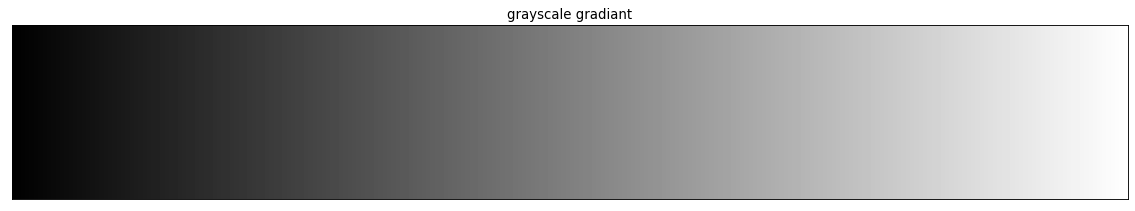

In [63]:
gradiant = np.repeat(np.arange(0, 256).reshape(1, 256), 40, axis=0)
displayImg(gradiant, subplot=111, cmap='gray', title= 'grayscale gradiant')

In [64]:
%%capture
# adding capture here to prevent the returned output from being evaluated by Jupyter (only the animation displayed in the next cell)
imgs = []
titles = []

for order in np.power(2, np.arange(1, 8)):
    imgs.append( bayerDithering( gradiant, order))
    titles.append('Order : ' + str(order))
anim = animateImages(imgs, titles, cmap='gray', interval = 300)

In [65]:
HTML(anim.to_jshtml())

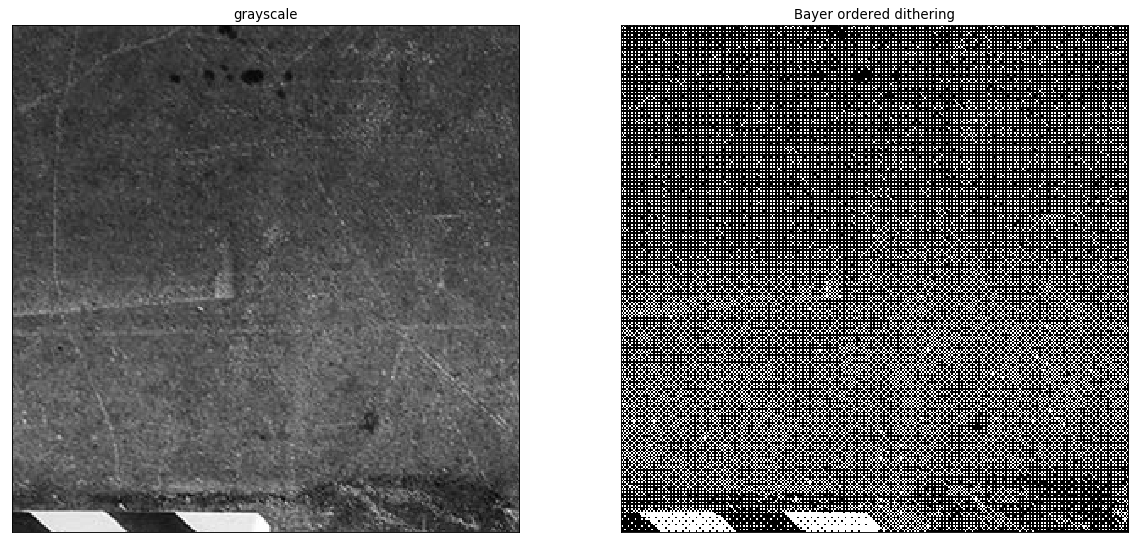

In [80]:
BayerThresholdImg = bayerDithering(grayscaleImg[:300, :300], 8)

displayImg(grayscaleImg[:300, :300], subplot=121, cmap='gray', title= 'grayscale')
displayImg(BayerThresholdImg, subplot=122, cmap='gray', title= 'Bayer ordered dithering')

In [ ]:
# def floydSteinberg(image, threshold = 0.5):
#     v, c, s = pic.shape
#     Floyd = np.copy(image)
#     for i in range(1, v-1):
#         for j in range(1, c-1):
#             quan = pic[i][j] - image[i][j] #Quantization error
#             Floyd[i][j + 1] = quan * (np.float(7 / 16)) + Floyd[i][j + 1]
#             Floyd[i + 1][j - 1] = quan * (np.float(3 / 16)) + Floyd[i + 1][j - 1]
#             Floyd[i + 1][j] = quan * (np.float(5 / 16)) + Floyd[i + 1][j]
#             Floyd[i + 1][j + 1] = quan * (np.float(1 / 16)) + Floyd[i + 1][j + 1]
#     return Floyd